# Analyzing Household Net Worth

This notebook presents analysis of affluent households in the US using data from the 2016 Federal Reserve [Survey of Consumer Finances](https://www.federalreserve.gov/econres/scfindex.htm). We explore the following questions:

* How rich are the top 1% and top 0.1%? 
* Are there different types of millionaires?
* How do asset allocations differ across different net worth segments? 

To answer these questions, we present descriptive statistics of this survey data and perform a cluster analysis on affluent households, which we identify as households with a net worth of more than $1,000,000 USD. 

## Load Libraries

In [15]:
library(readxl)     # for reading xlsx files 
library(reldist)    # for computing weighted statistics
library(ENmisc)     # for weighted box plots
library(plotly)     # for interactive plots
library(factoextra) # for factor maps
library(FactoMineR) # PCA
library(cluster)    # Clustering algorithms (CLARA)
library(class)      # for KNN

## Download the Data Set

In [2]:
if (!file.exists("SCFP2016.xlsx")) {
  download.file("https://www.federalreserve.gov/econres/files/scfp2016excel.zip", "SCFP2016.zip")
  unzip("scfp2016.zip")
} 

df <- read_excel("SCFP2016.xlsx") 
df[df$NETWORTH < 0, ]$NETWORTH <- 0 # if net worth is less than 0, assign a value of zero

## Summary Stats

In [3]:
cat(paste("Number of survey participants:", nrow(df)))
cat(paste("\nNumber of US Households:", floor(sum(df$WGT))))
cat(paste0("\nMean household Net Worth: $", floor(sum(df$NETWORTH*df$WGT)/sum(df$WGT))))


Number of survey participants: 31240
Number of US Households: 125981700
Mean household Net Worth: $692980

## Computing Weighted Statistics

In [4]:
# What is the median NW in US? 
reldist::wtd.quantile(df$NETWORTH, q=0.5, na.rm = FALSE, weight = df$WGT)

# Who are the 1%?
reldist::wtd.quantile(df$NETWORTH, q=0.99, na.rm = FALSE, weight = df$WGT)

# Top 0.1% Ultra-high net worth households 
reldist::wtd.quantile(df$NETWORTH, q=0.999, na.rm = FALSE, weight = df$WGT)


50% 
97290

99% 
10350300

99.9% 
43168000

## New Worth by Demographics

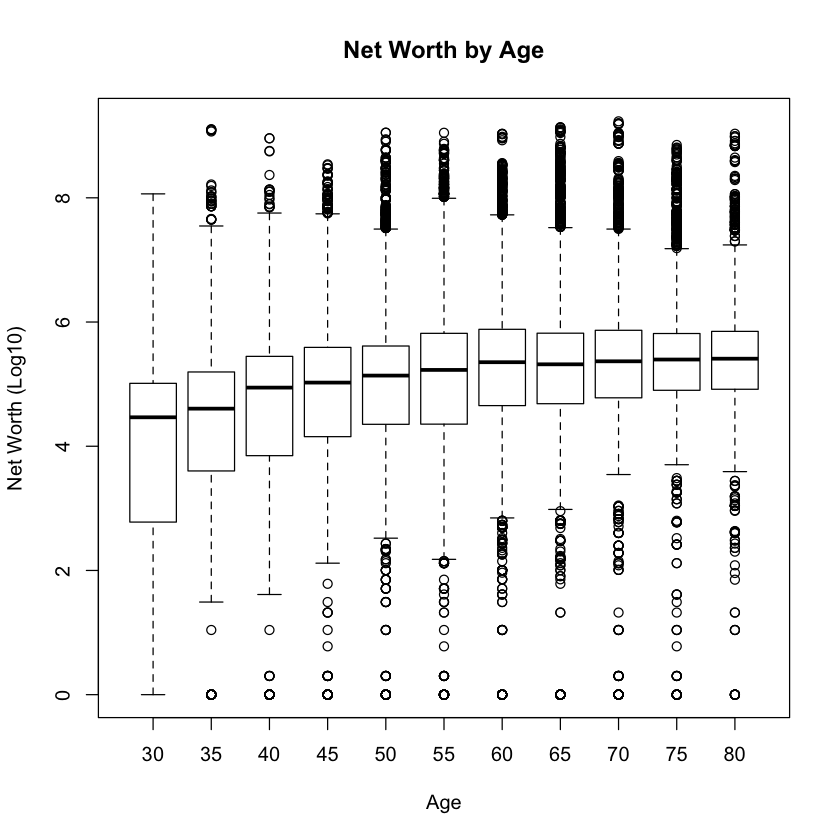

In [5]:
# plot net worth by age groups 
data <- df[df$AGE >= 30 & df$AGE < 85, ]
ages <- floor(data$AGE/5.0)*5

wtd.boxplot(log10(1 + data$NETWORTH) ~ ages, data = data, weights = data$WGT
            ,main = 'Net Worth by Age'
            , xlab="Age", ylab="Net Worth (Log10)")

## Distribution of Assets by Net Worth Segment

In [19]:
assets <- df$FIN + df$NFIN

# normalize asset amounts by total financial and non-financial assets (exclude debt)
households <- data.frame(
  netWorth = df$NETWORTH,
  weight = df$WGT,
  LIQ = df$LIQ/assets, 
  CDS = df$CDS/assets, 
  NMMF = df$NMMF/assets,
  STOCKS = df$STOCKS/assets, 
  BOND = df$BOND/assets,    
  RETQLIQ = df$RETQLIQ/assets,    
  SAVBND = df$SAVBND/assets,
  CASHLI = df$CASHLI/assets,
  OTHMA = df$OTHMA/assets,  
  OTHFIN = df$OTHFIN/assets, 
  PREPAID = df$PREPAID/assets, 
  VEHIC = df$VEHIC/assets, 
  HOUSES = df$HOUSES/assets,  
  ORESRE = df$ORESRE/assets, 
  NNRESRE = df$NNRESRE/assets, 
  BUS = df$BUS/assets,  
  OTHNFIN = df$OTHNFIN/assets
)

# group households into segments
households <- households[households$netWorth >= 10000, ]

# split into net worth segments 
nw <- floor(log10(households$netWorth))
segment <- ifelse(nw == 4, "     $10k", 
      ifelse(nw == 5, "    $100K", 
      ifelse(nw == 6, "   $1M",               
      ifelse(nw == 7, "  $10M",               
      ifelse(nw == 8, " $100M",               
                      "$1B+"))))) 

# compute average asset distrubtions
results <- as.data.frame((aggregate(households,list(segment),mean)))  

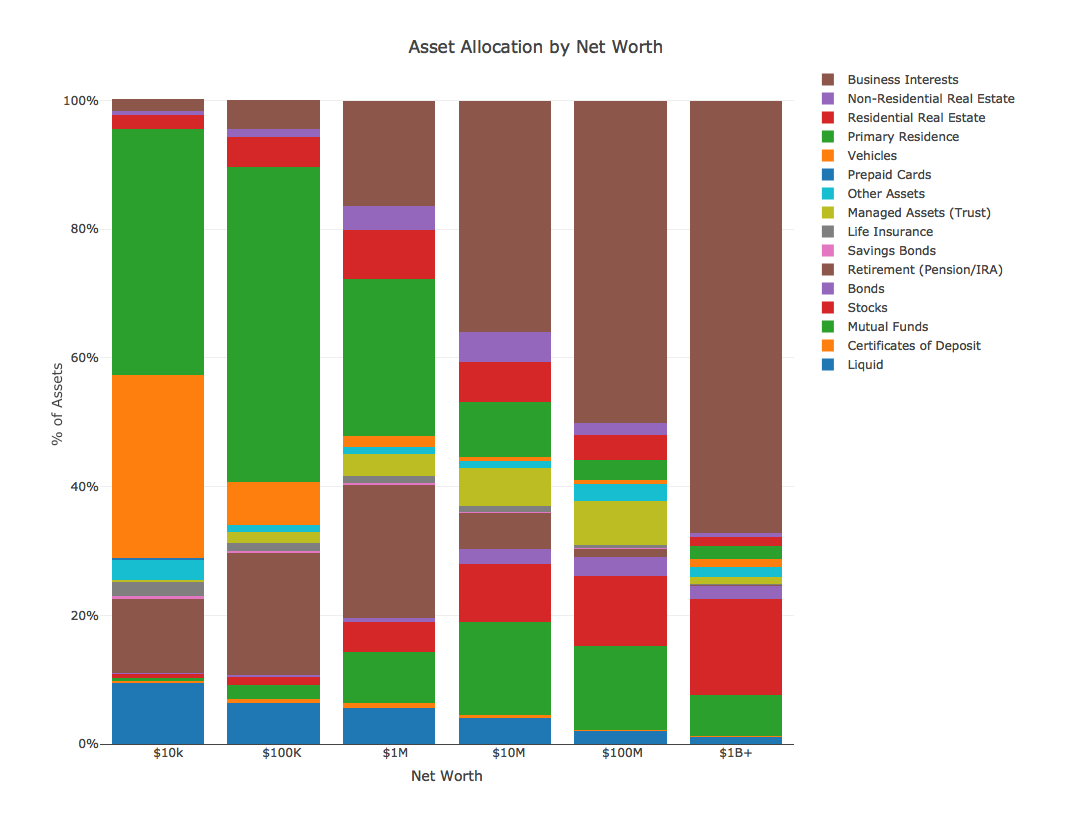

In [17]:
plot <- plot_ly(results, x = ~Group.1, y = ~100*LIQ, type = 'bar', name = 'Liquid') %>%
  add_trace(y = ~100*CDS, name = 'Certificates of Deposit') %>%
  add_trace(y = ~100*NMMF, name = 'Mutual Funds') %>%
  add_trace(y = ~100*STOCKS, name = 'Stocks') %>%
  add_trace(y = ~100*BOND, name = 'Bonds') %>%
  add_trace(y = ~100*RETQLIQ, name = 'Retirement (Pension/IRA)') %>%
  add_trace(y = ~100*SAVBND, name = 'Savings Bonds') %>%
  add_trace(y = ~100*CASHLI, name = 'Life Insurance') %>%
  add_trace(y = ~100*OTHMA, name = 'Managed Assets (Trust)') %>%
  add_trace(y = ~(100*OTHFIN + 100*OTHNFIN), name = 'Other Assets') %>%
  add_trace(y = ~100*PREPAID, name = 'Prepaid Cards') %>%
  add_trace(y = ~100*VEHIC, name = 'Vehicles') %>%
  add_trace(y = ~100*HOUSES, name = 'Primary Residence') %>%
  add_trace(y = ~100*ORESRE, name = 'Residential Real Estate') %>%
  add_trace(y = ~100*NNRESRE, name = 'Non-Residential Real Estate') %>%
  add_trace(y = ~100*BUS, name = 'Business Interests') %>%
  layout(yaxis = list(title = '% of Assets', ticksuffix = "%"), xaxis = list(title = "Net Worth"),
         title = "Asset Allocation by Net Worth", barmode = 'stack')

# show as png
export(plot, file = "plot.png")
IRdisplay::display_png(file="plot.png")  


## Clustering Millionaires

In [20]:
#how many millionaires are there? 
affluent <- households[households$netWorth >= 1000000, ]
cat(paste("Affluent Households: ", floor(sum(affluent$weight))))

# store these variables for later 
weights <- households$weight
nwHouseholds <- households$netWorth
households$weight <- NULL
affluent$weight <- NULL
households$netWorth <- NULL
affluent$netWorth <- NULL


Affluent Households:  14822597

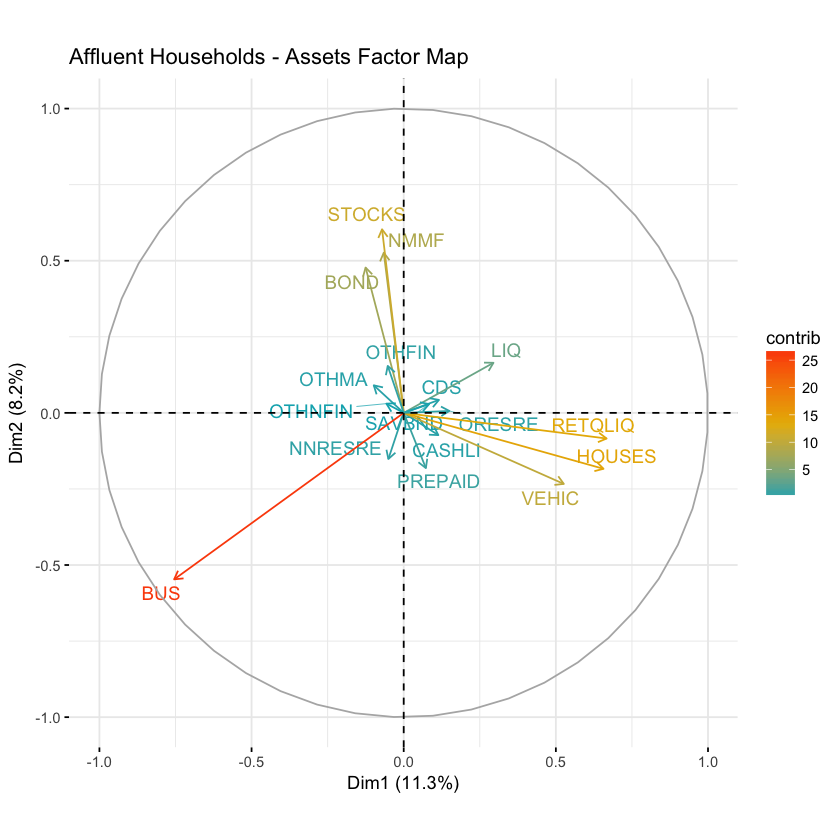

In [21]:
# Plot a factor map of affluent assets 
fviz_pca_var(PCA(affluent,  graph = FALSE), col.var="contrib",  
  gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), repel = TRUE) + 
  labs(title ="Affluent Households - Assets Factor Map")

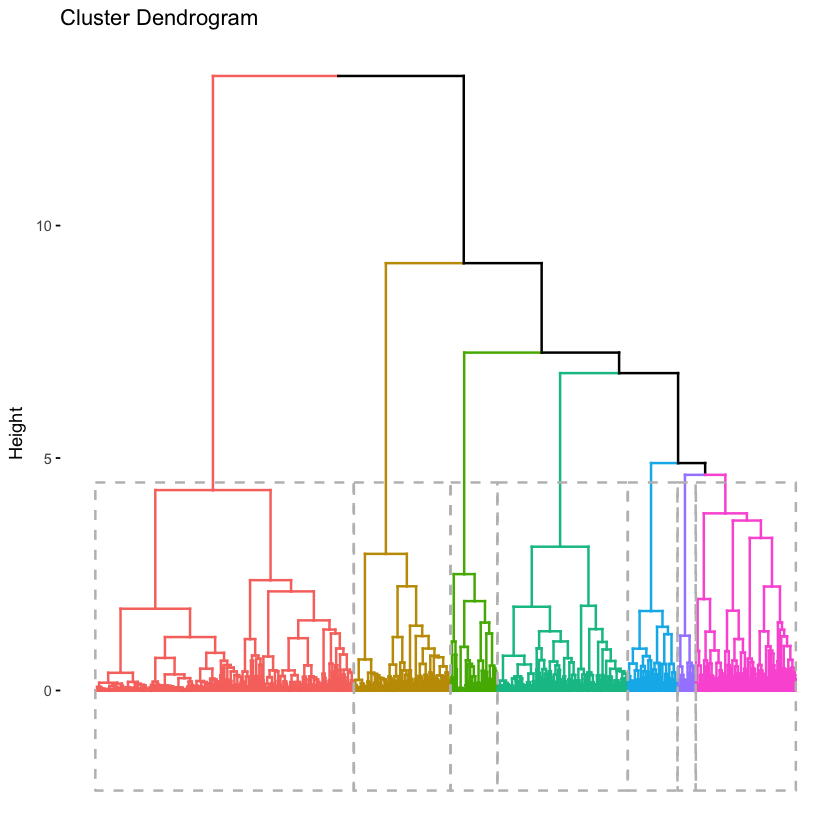

In [10]:
##fviz_nbclust(affluent, clara, method = "silhouette")
k <- 7
res.hc <- eclust(households[sample(nrow(households), 1000), ], "hclust", k = k, graph = FALSE) 
fviz_dend(res.hc, rect = TRUE, show_labels = FALSE)

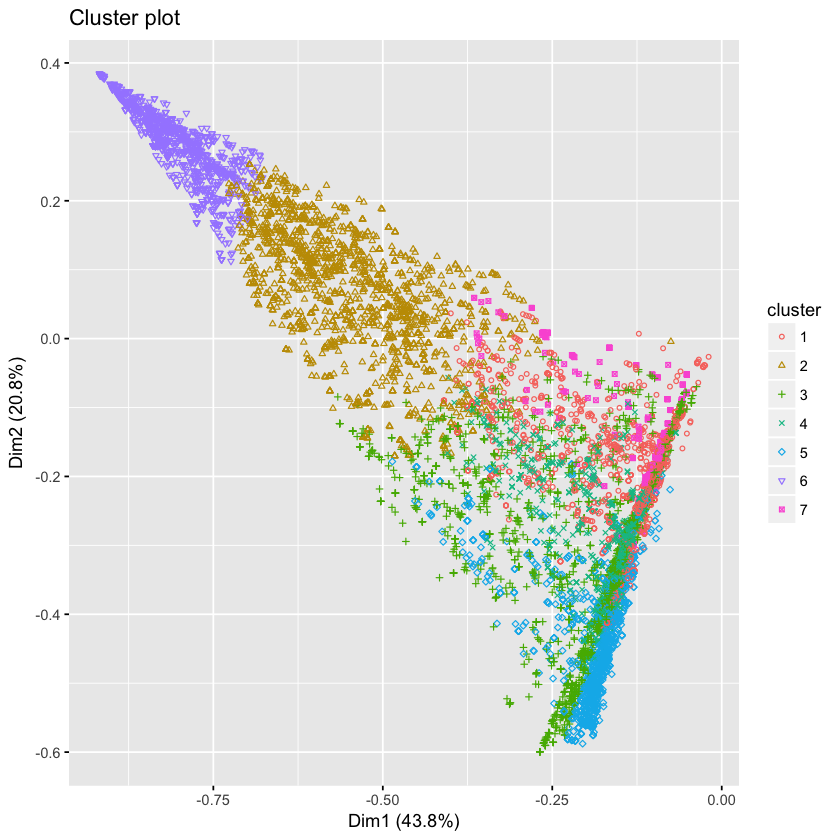

In [11]:
# Plot a PCA visualization of the clusters
clarax <- clara(affluent, k)
fviz_cluster(clarax, stand = FALSE, geom = "point", pointsize = 1, ellipse = F)

## Describe the Cluster Features

In [22]:
groups <- clarax$clustering
#table(groups)

results <- as.data.frame(t(aggregate(affluent,list(groups),mean)))  

for (name in names(results)) {
  results[name] <- round(results[,name], 3)  
} 

results[2:18,]

,V1,V2,V3,V4,V5,V6,V7
LIQ,0.066,0.036,0.053,0.043,0.068,0.017,0.041
CDS,0.010,0.004,0.008,0.005,0.006,0.001,0.005
NMMF,0.118,0.063,0.027,0.500,0.031,0.013,0.021
STOCKS,0.261,0.036,0.034,0.038,0.026,0.010,0.024
BOND,0.046,0.010,0.007,0.015,0.003,0.002,0.003
RETQLIQ,0.097,0.061,0.102,0.109,0.480,0.016,0.045
SAVBND,0.001,0.001,0.001,0.001,0.002,0.000,0.000
CASHLI,0.011,0.009,0.010,0.010,0.012,0.006,0.004
OTHMA,0.043,0.039,0.119,0.023,0.020,0.006,0.021
OTHFIN,0.011,0.006,0.008,0.005,0.005,0.001,0.008


### Cluster Descriptions

* Cluster V1: Stocks - 31% of assets (w/ Bonds), followed by home 11% and mutual funds 11% 
* Cluster V2: Diversified - 53% busequity, 10% home and 9% in other real estate 
* Cluster V3: Residential Real Estate - 48% of assets 
* Cluster V4: Mutual Funds - 50% of assets 
* Cluster V5: Retirement - 48% of assets 
* Cluster V6: Business Equity - 85% of assets 
* Cluster V7: Commercial Real Estate - 59% of assets 


## Cluster Distribution by Net Worth Segments

In [23]:
groups <- knn(train = affluent, test = households, cl = clarax$clustering, k = k, prob = T, use.all = T)

# figure out how many households are assigned to each cluster
clusters <- data.frame(
  c1 = ifelse(groups == 1, weights, 0), 
  c2 = ifelse(groups == 2, weights, 0), 
  c3 = ifelse(groups == 3, weights, 0), 
  c4 = ifelse(groups == 4, weights, 0), 
  c5 = ifelse(groups == 5, weights, 0), 
  c6 = ifelse(groups == 6, weights, 0), 
  c7 = ifelse(groups == 7, weights, 0) 
)

# assign each household to a net worth cluster 
nw <- floor(2*log10(nwHouseholds))/2
results <- as.data.frame(t(aggregate(clusters,list(nw),sum)))  

# store the labels before transposing the data frame 
labels <- results[1, ]
results <- results[2:8, ]

# compute the number of households that belong to each cluster for each net worth segment
results$V1 <- results$V1/sum(ifelse(nw == 4, weights, 0))
results$V2 <- results$V2/sum(ifelse(nw == 4.5, weights, 0))
results$V3 <- results$V3/sum(ifelse(nw == 5, weights, 0))
results$V4 <- results$V4/sum(ifelse(nw == 5.5, weights, 0))
results$V5 <- results$V5/sum(ifelse(nw == 6, weights, 0))
results$V6 <- results$V6/sum(ifelse(nw == 6.5, weights, 0))
results$V7 <- results$V7/sum(ifelse(nw == 7, weights, 0))
results$V8 <- results$V8/sum(ifelse(nw == 7.5, weights, 0))
results$V9 <- results$V9/sum(ifelse(nw == 8, weights, 0))
results$V10 <- results$V10/sum(ifelse(nw == 8.5, weights, 0))
results$V11 <- results$V11/sum(ifelse(nw == 9, weights, 0))
results <- rbind(labels, results)
results <- as.data.frame(t(results))


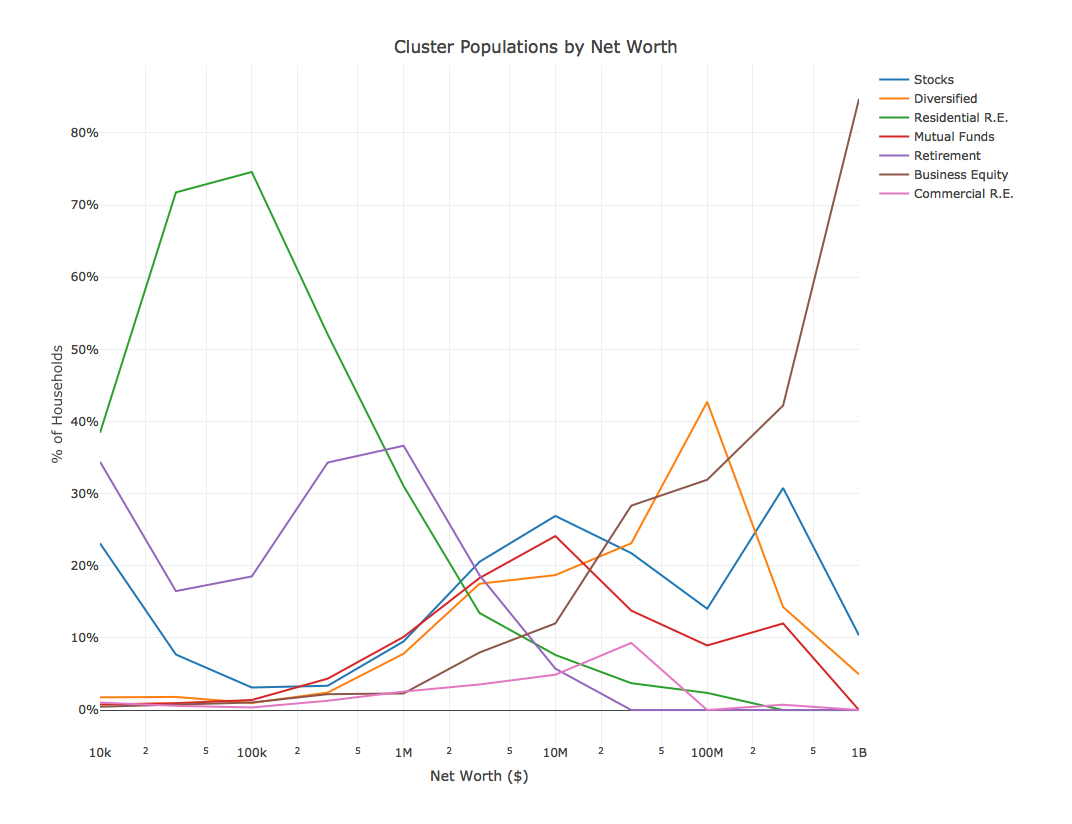

In [24]:
plot <- plot_ly(results, x = ~10^Group.1, y = ~100*c1, type = 'scatter', mode = 'lines', name = "Stocks") %>%
  add_trace(y = ~100*c2, name = "Diversified") %>%
  add_trace(y = ~100*c3, name = "Residential R.E.") %>%
  add_trace(y = ~100*c4, name = "Mutual Funds") %>%
  add_trace(y = ~100*c5, name = "Retirement") %>%
  add_trace(y = ~100*c6, name = "Business Equity") %>%
  add_trace(y = ~100*c7, name = "Commercial R.E.") %>%
  layout(yaxis = list(title = '% of Households', ticksuffix = "%"), 
         xaxis = list(title = "Net Worth ($)", type = "log"), title = "Cluster Populations by Net Worth")

# show as png
export(plot, file = "plot.png")
IRdisplay::display_png(file="plot.png")  